<h1> Problem 1 </h1>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [3]:
# download data
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
def accuracy_fn(labels, predictions):
    matches = tf.where(tf.equal(labels, tf.cast(predictions, tf.int32)),
                       x = tf.ones(tf.shape(labels)),
                       y = tf.zeros(tf.shape(labels)))
    return tf.reduce_mean(matches)

# Define model
def model():
    # define placeholders
    features_ph = tf.placeholder(dtype=tf.float32, shape=(None, 28, 28))
    labels_ph = tf.placeholder(dtype=tf.int32, shape=(None))
    learning_rate_ph = tf.placeholder(dtype=tf.float32, shape=())
    dropout_ph = tf.placeholder(dtype=tf.float32, shape=())
    
    # flatten layer
    flatten_images = tf.layers.flatten(features_ph)
    
    # hidden layer 1
    layer_1 = tf.layers.dense(flatten_images, 300, activation=tf.nn.leaky_relu)
    layer_1 = tf.layers.dropout(layer_1, rate=dropout_ph)
    
    # hidden layer 2
    layer_2 = tf.layers.dense(layer_1, 200, activation=tf.nn.leaky_relu)
    layer_2 = tf.layers.dropout(layer_2, rate=dropout_ph)
    
    # hidden layer 3
    layer_3 = tf.layers.dense(layer_2, 100, activation=tf.nn.leaky_relu)
    layer_3 = tf.layers.dropout(layer_3, rate=dropout_ph)
    
    # output_layer
    logits = tf.layers.dense(layer_3, 10, activation=None)

    # loss
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels_ph,
                                                  logits=logits)
    
    # predictions
    predictions = tf.argmax(logits, 1)
    
    # accuracy
    accuracy = accuracy_fn(labels_ph, predictions)
    
    # training op
    train = tf.train.GradientDescentOptimizer(learning_rate_ph).minimize(loss)
    
    return features_ph, labels_ph, loss, accuracy,\
               predictions, train, learning_rate_ph, dropout_ph

features_ph, labels_ph, loss, accuracy,\
               predictions, train, learning_rate_ph, dropout_ph = model()

In [5]:
# define an iterator to repeatedly go through the data
def mini_batches_iterator(x, y, batch_size, n_epochs):
    index = -1
    n_data = len(y)
    for epoch in range(n_epochs):
        print("epoch {}".format(epoch + 1))
        indices = np.arange(0, n_data, 1)
        np.random.shuffle(indices)
        for i in range(0, n_data - batch_size, batch_size):
            x_batch = x[indices[i:i+batch_size]]
            y_batch = y[indices[i:i+batch_size]]
            
            index += 1
            
            yield index, x_batch, y_batch

In [6]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())

In [7]:
indexes = []
test_losses = []
test_accs = []
for index, x_batch, y_batch in\
        mini_batches_iterator(x_train, y_train, 50, 10):
    l, acc, _ = sess.run([loss, accuracy, train],
                         feed_dict={features_ph:x_batch,
                                    labels_ph:y_batch,
                                    learning_rate_ph:0.02,
                                    dropout_ph:0.1})
    if index % 100 == 0:
        test_l, test_acc = sess.run([loss, accuracy],
                                    feed_dict={features_ph:x_test,
                                               labels_ph:y_test,
                                               dropout_ph:0.0})
        indexes.append(index)
        test_losses.append(test_l)
        test_accs.append(test_acc)
        print("step {}: train loss: {}, train accuracy {}".format(index, str(round(l, 4)), str(round(acc, 4))))
        print("step {}: test loss: {}, test accuracy {}"\
                  .format(index, str(round(test_l, 4)), str(round(test_acc, 4))))
        print()


epoch 1
step 0: train loss: 2.3097, train accuracy 0.08
step 0: test loss: 2.316, test accuracy 0.085

step 100: train loss: 1.2151, train accuracy 0.74
step 100: test loss: 1.0944, test accuracy 0.7718

step 200: train loss: 0.6596, train accuracy 0.78
step 200: test loss: 0.5963, test accuracy 0.8405

step 300: train loss: 0.5653, train accuracy 0.8
step 300: test loss: 0.4524, test accuracy 0.8798

step 400: train loss: 0.4877, train accuracy 0.88
step 400: test loss: 0.389, test accuracy 0.8919

step 500: train loss: 0.6902, train accuracy 0.82
step 500: test loss: 0.3637, test accuracy 0.8961

step 600: train loss: 0.3451, train accuracy 0.9
step 600: test loss: 0.3379, test accuracy 0.9031

step 700: train loss: 0.2762, train accuracy 0.9
step 700: test loss: 0.3196, test accuracy 0.9098

step 800: train loss: 0.2043, train accuracy 0.94
step 800: test loss: 0.3111, test accuracy 0.9114

step 900: train loss: 0.4654, train accuracy 0.94
step 900: test loss: 0.3189, test accuracy 

step 8000: train loss: 0.0951, train accuracy 0.98
step 8000: test loss: 0.1122, test accuracy 0.9657

step 8100: train loss: 0.1921, train accuracy 0.96
step 8100: test loss: 0.1121, test accuracy 0.9662

step 8200: train loss: 0.0485, train accuracy 1.0
step 8200: test loss: 0.1113, test accuracy 0.9668

step 8300: train loss: 0.0361, train accuracy 0.98
step 8300: test loss: 0.1071, test accuracy 0.9659

epoch 8
step 8400: train loss: 0.0575, train accuracy 0.98
step 8400: test loss: 0.1088, test accuracy 0.9677

step 8500: train loss: 0.0449, train accuracy 0.98
step 8500: test loss: 0.1056, test accuracy 0.9688

step 8600: train loss: 0.0244, train accuracy 1.0
step 8600: test loss: 0.1052, test accuracy 0.9669

step 8700: train loss: 0.0467, train accuracy 1.0
step 8700: test loss: 0.1111, test accuracy 0.9661

step 8800: train loss: 0.0492, train accuracy 1.0
step 8800: test loss: 0.1026, test accuracy 0.9698

step 8900: train loss: 0.0566, train accuracy 1.0
step 8900: test los

In [8]:
show_graph(tf.get_default_graph())

In [9]:
# Run this block in case you want to close the session and reset the graph
sess.close()
tf.reset_default_graph()

Text(0, 0.5, 'accuracy')

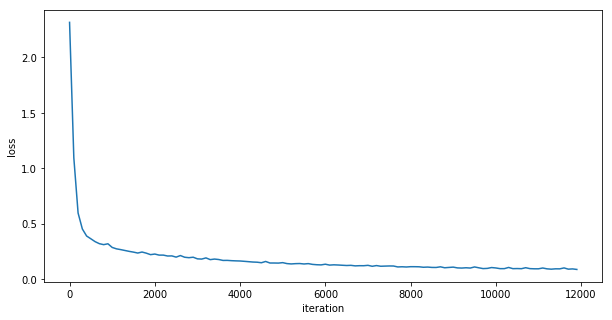

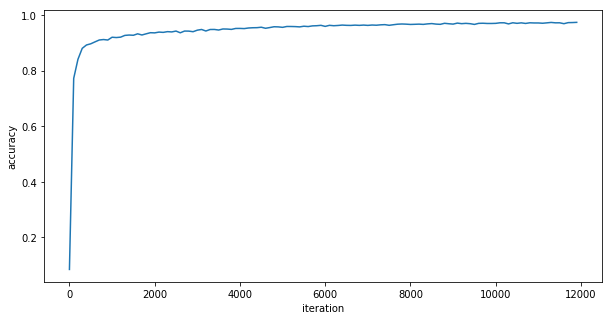

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(indexes, test_losses)
plt.xlabel("iteration")
plt.ylabel("loss")

plt.figure(figsize=(10, 5))
plt.plot(indexes, test_accs)
plt.xlabel("iteration")
plt.ylabel("accuracy")

<h1> Problem 2 </h1>

In [442]:
import tensorlayer
def better_model_2():
    # define placeholders
    features_ph = tf.placeholder(dtype=tf.float32, shape=(None, 28, 28), name="features")
    labels_ph = tf.placeholder(dtype=tf.int32, shape=(None), name="labels")
    dropout_ph = tf.placeholder(dtype=tf.float32, shape=(), name="dropout")

    # resize images to 4D tensor
    reshaped_input = tf.reshape(features_ph, (-1, 28, 28, 1))

    with tf.name_scope("conv_layer_1"):
        # Convolutional Layer 1
        conv1 = tf.layers.conv2d(
          inputs=reshaped_input,
          filters=32,
          kernel_size=[5, 5],
          padding="same",
          activation=None)
        conv1 = tf.layers.batch_normalization(conv1)
        conv1 = tensorlayer.activation.swish(conv1)

        # Pooling Layer 1
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    with tf.name_scope("conv_layer_2"):
        # Convolutional Layer 2 and Pooling Layer 2
        conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=None)
        conv2 = tf.layers.batch_normalization(conv2)
        conv2 = tensorlayer.activation.swish(conv2)
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    
    # output_layers
    with tf.name_scope("output_layer"):
        output_layer = tf.layers.dense(pool2_flat, 300, activation=None, use_bias=False,
                                      kernel_initializer=tf.initializers.random_uniform(-0.1, 0.1))
        output_layer = tf.layers.batch_normalization(output_layer)
        output_layer = tensorlayer.activation.swish(output_layer)
        output_layer = tf.layers.dropout(output_layer, rate=dropout_ph)
        logits = tf.layers.dense(output_layer, 10, activation=None,
                                 kernel_initializer=tf.initializers.random_uniform(-0.1, 0.1))
        

    # loss
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels_ph,
                                                  logits=logits)
    
    # predictions
    predictions = tf.arg_max(logits, 1)
    
    # accuracy
    accuracy = accuracy_fn(labels_ph, predictions)
    
    # training op
    train = tf.train.AdamOptimizer().minimize(loss)
    
    # summaries
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('accuracy', accuracy)
    merged = tf.summary.merge_all()
    
    return features_ph, labels_ph, loss, accuracy,\
               predictions, train, dropout_ph, merged

features_ph, labels_ph, loss, accuracy,\
    predictions, train, dropout_ph, merged = better_model_2()

In [443]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
global_index = 0

In [444]:
# you can run this block several times to train the network for 40 epochs each time you run it
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
test_writer = tf.summary.FileWriter(os.path.join(os.getcwd(), 'conv_tensorboard/test'), sess.graph)
train_writer = tf.summary.FileWriter(os.path.join(os.getcwd(), 'conv_tensorboard/train'), sess.graph)

indexes = []
test_losses = []
test_accs = []
for index, x_batch, y_batch in\
        mini_batches_iterator(x_train, y_train, 32, 40):
    l, acc, _, _ = sess.run([loss, accuracy, train, extra_update_ops],
                         feed_dict={features_ph:x_batch,
                                    labels_ph:y_batch,
                                    dropout_ph:0.7})
    if index % 10 == 0:
        # The loss computing takes too much time if done on the whole dataset each time
        # test summaries
        indices = np.random.choice(np.arange(0, len(y_test), 1), size=500, replace=False)
        summaries, _, _ = sess.run([merged, loss, accuracy],
                                   feed_dict={features_ph:x_test[indices],
                                              labels_ph:y_test[indices],
                                              dropout_ph:0.0})
        test_writer.add_summary(summaries, global_index)
        
        # train summaries
        indices = np.random.choice(np.arange(0, len(y_train), 1), size=500, replace=False)
        summaries, _, _ = sess.run([merged, loss, accuracy],
                                   feed_dict={features_ph:x_train[indices],
                                              labels_ph:y_train[indices],
                                              dropout_ph:0.0})
        train_writer.add_summary(summaries, global_index)
    
    global_index += 1

final_loss, final_accuracy = sess.run([loss, accuracy],
                                      feed_dict={features_ph:x_test,
                                                 labels_ph:y_test,
                                                 dropout_ph:0.0})
print("final accuracy: ", final_accuracy)
print("final loss: ", final_loss)

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
final accuracy:  0.9925
final loss:  0.07003816


In [441]:
# Run this block in case you want to close the session and reset the graph
sess.close()
tf.reset_default_graph()